In [1]:
cd D:/food-detection

D:\food-detection


In [2]:
pwd

'D:\\food-detection'

In [3]:
import requests
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

print('Dependencies Imported')

Dependencies Imported


In [4]:
print(tf.__version__)
print(tf.test.gpu_device_name())
api_url = 'https://api.calorieninjas.com/v1/nutrition?query='
query = 'french fries'
response = requests.get(api_url + query, headers={'X-Api-Key': 's9S3fiY9BWYZtpCebS71Rg==Qk1nbauJKhKE9k8R'})
if response.status_code == requests.codes.ok:
    print(response.text)
else:
    print("Error:", response.status_code, response.text)

2.4.0
/device:GPU:0
{"items": [{"sugar_g": 0.3, "fiber_g": 3.8, "serving_size_g": 100.0, "sodium_mg": 209, "name": "french fries", "potassium_mg": 123, "fat_saturated_g": 2.3, "fat_total_g": 14.4, "calories": 312.5, "cholesterol_mg": 0, "protein_g": 3.4, "carbohydrates_total_g": 42.1}]}


In [5]:
os.listdir('food-101/') 

['images', 'meta', 'README.txt']

In [6]:
os.listdir('food-101/images')

['donuts',
 'french_fries',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'pizza',
 'samosa',
 'spring_rolls',
 'sushi',
 'waffles']

In [7]:
os.listdir('food-101/meta')

['classes.txt', 'labels.txt', 'test.txt', 'train.txt']

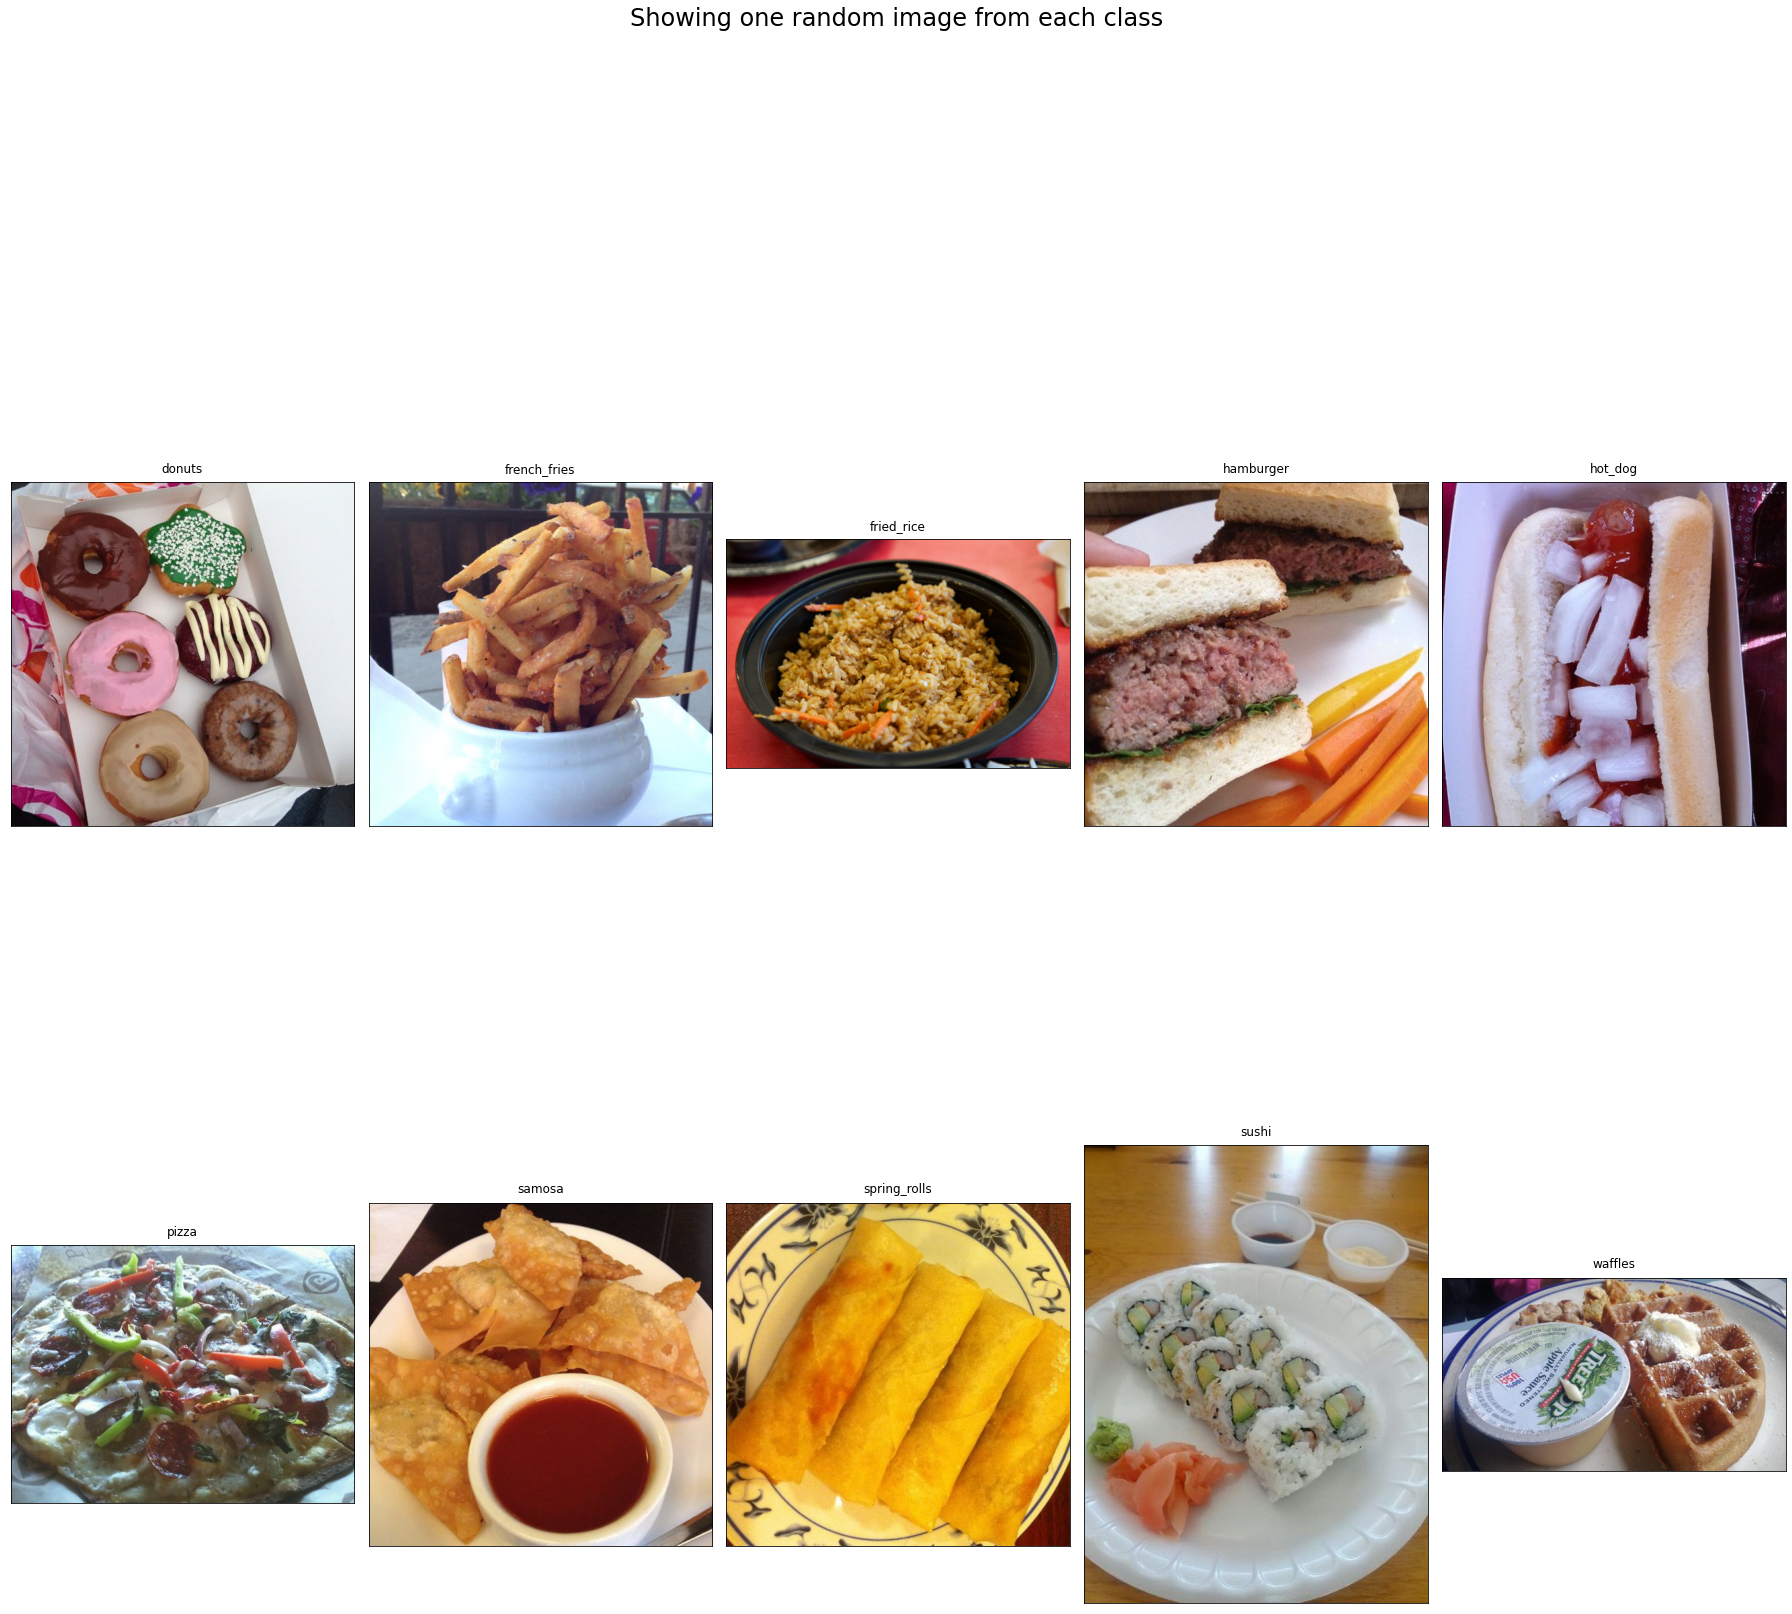

In [10]:
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24)
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected))
    food_selected_random = np.random.choice(food_selected_images)
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [11]:
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [12]:
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

Creating train data...

Copying images into  donuts

Copying images into  french_fries

Copying images into  fried_rice

Copying images into  hamburger

Copying images into  hot_dog

Copying images into  pizza

Copying images into  samosa

Copying images into  spring_rolls

Copying images into  sushi

Copying images into  waffles
Copying Done!


In [13]:
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

Creating test data...

Copying images into  donuts

Copying images into  french_fries

Copying images into  fried_rice

Copying images into  hamburger

Copying images into  hot_dog

Copying images into  pizza

Copying images into  samosa

Copying images into  spring_rolls

Copying images into  sushi

Copying images into  waffles
Copying Done!


In [14]:
foods_sorted

['donuts',
 'french_fries',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'pizza',
 'samosa',
 'spring_rolls',
 'sushi',
 'waffles']

In [15]:
food_list = ['donuts',
 'french_fries',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'pizza',
 'samosa',
 'spring_rolls',
 'sushi',
 'waffles']

In [16]:
K.clear_session()
n_classes = 10
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 7500
nb_validation_samples = 2500
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(10,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_10class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_10class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_10class.hdf5')


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
C:\Users\yashb\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/30


KeyboardInterrupt: 

In [17]:
class_map_10 = train_generator.class_indices
class_map_10

{'donuts': 0,
 'french_fries': 1,
 'fried_rice': 2,
 'hamburger': 3,
 'hot_dog': 4,
 'pizza': 5,
 'samosa': 6,
 'spring_rolls': 7,
 'sushi': 8,
 'waffles': 9}

In [19]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


In [20]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

NameError: name 'history' is not defined

In [21]:
K.clear_session()
print("Loading the model..")
model = load_model('best_model_10class.hdf5',compile = False)
print("Done!")

Loading the model..
Done!


In [22]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
        print(pred_value)
        
    api_url = 'https://api.calorieninjas.com/v1/nutrition?query='
    query = pred_value.replace("_"," ")
    response = requests.get(api_url + query, headers={'X-Api-Key': 's9S3fiY9BWYZtpCebS71Rg==Qk1nbauJKhKE9k8R'})
    if response.status_code == requests.codes.ok:
        print(response.text)
    else:
        print("Error:", response.status_code, response.text)

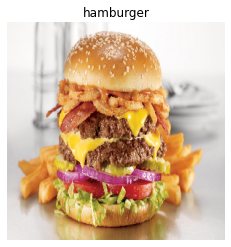

hamburger
{"items": [{"sugar_g": 0.0, "fiber_g": 0.0, "serving_size_g": 100.0, "sodium_mg": 349, "name": "hamburger", "potassium_mg": 138, "fat_saturated_g": 4.7, "fat_total_g": 11.8, "calories": 242.5, "cholesterol_mg": 54, "protein_g": 15.2, "carbohydrates_total_g": 17.9}]}


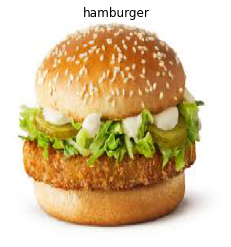

hamburger
{"items": [{"sugar_g": 0.0, "fiber_g": 0.0, "serving_size_g": 100.0, "sodium_mg": 349, "name": "hamburger", "potassium_mg": 138, "fat_saturated_g": 4.7, "fat_total_g": 11.8, "calories": 242.5, "cholesterol_mg": 54, "protein_g": 15.2, "carbohydrates_total_g": 17.9}]}


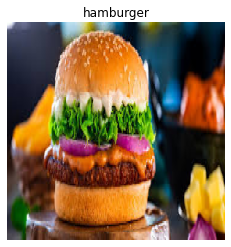

hamburger
{"items": [{"sugar_g": 0.0, "fiber_g": 0.0, "serving_size_g": 100.0, "sodium_mg": 349, "name": "hamburger", "potassium_mg": 138, "fat_saturated_g": 4.7, "fat_total_g": 11.8, "calories": 242.5, "cholesterol_mg": 54, "protein_g": 15.2, "carbohydrates_total_g": 17.9}]}


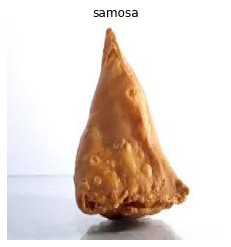

samosa
{"items": [{"sugar_g": 1.6, "fiber_g": 2.1, "serving_size_g": 100.0, "sodium_mg": 426, "name": "samosa", "potassium_mg": 52, "fat_saturated_g": 7.1, "fat_total_g": 17.4, "calories": 260.8, "cholesterol_mg": 27, "protein_g": 3.5, "carbohydrates_total_g": 24.2}]}


In [23]:
images = []
images.append('img/burger.jpg')
images.append('img/burger3.jpg')
images.append('img/burgermc.jpg')
images.append('img/s1.jpg')
predict_class(model, images, True)

In [27]:
model.summary()

                 
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, None, None, 1 576         conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, None, None, 1 0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, None, None, 1 0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_68 (Activation)      (None, None, None, 1 0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
activation_69 (Activation)      (None, None, None, 1 0           batch_normalization_69[0][